# HW 8

##### From SAV to LOVE

## Введение в обработку естественного языка
### Урок 8. Рекуррентные нейронные сети RNN LSTM GRU

### Практическое задание  
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими, необходимо выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара.  
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. попробовать использовать совместно CNN и RNN
4. сдлать выводы что получилось лучше

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# !pip install stop_words
# !pip install pymorphy2
# !pip install gensim

In [4]:
import time

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [7]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Tensorflow with GPU

In [8]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

### Загрузка данных

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [103]:
# df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/train.csv')
# df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/test.csv')
# df_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/val.csv')
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/val.csv')

### Изучение датасета

In [104]:
df_train.head()

,id,text,class
0,0,"@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.",0
1,1,"RT @GalyginVadim: Ребята и девчата!\r\nВсе в кино!!! ""Вот Это Любовь!""\r\nСегодня! Завтра! И потом!)))))\r\n#вотэтолюбовь",1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :),1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......)),1


In [105]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не получилось(( ну и хрен с ним"
2,204152,"Хочу лето только ради того, что бы направить ногти ярким лаком :)"
3,204153,"RT @RonyLiss: @colf_ne блин((\r\nа я шипперила ФлораБлум\r\nИ МузаТекна\r\nА Стеллу.. не помню, ахах"
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое воскресенье утром выходит:( а сегодня ..какашка:(просто я иду человека фоткать и мне нужно солн…"


In [106]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #євромайдан http://t.co/wxtQ0xGVtp,1
1,181468,"чтоб у меня з.п. ежегодно индексировали на индекс инфляции, как тарифы на автобусы! :(",0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха честн не помню , я тебе завтра в шк покажу как меня прикона пиздят ~((((",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


In [107]:
df_train.tail()

,id,text,class
181462,181462,Классным будет новый год..( http://t.co/LejaGuXNwu,0
181463,181463,Видишь человека хочешь сказать ему привет . А он тебя игнорит :(,0
181464,181464,@Julia6_9Styles там длинный диагноз. Вкратце: аллергический отёк горла с осложнением в виде фолликулярной ангины :(,0
181465,181465,"@technoslav ух ты, а кому тот серенький кнопочне телефон достанется ;)",1
181466,181466,"@Kris1D_07 я тоже так собираюсь сделать:D навешаю фоток вандюх:D \r\nобязательно выложи фотку, как нарядишь:3",1


In [108]:
df_test.tail()

,id,text
22679,226829,"RT @NickValuev: Небоскребы, небоскребы, а я маленький такой:) http://t.co/ZJ3H12KPPK"
22680,226830,"Первый день в школе в новом году;( 3 человека спросили: все ли у меня в порядке?.. Черный я любою, вот и все"
22681,226831,RT @Killgay_slut: @Your_Novocaine привеееет муда... какой к черту Сэмми? (
22682,226832,"Настроение вроде нормальное, но от чего плакать хочется("
22683,226833,"зашла перед сном к девчонкам)пока они мыли посуду,Настя фоткалась) http://t.co/kiNexuDTuh"


In [109]:
df_val.tail()

,id,text,class
22678,204145,А я знаю из-за кого такая паршивая погода была сегодня))),1
22679,204146,ааа.... что с Гмейлом. не ужто он умер сегодня :( именно в тот день когда мне надо сдавать журнал в печать,0
22680,204147,"в учебники химии написано ""Пруст Жозеф Луи""\r\nя явно подумала не о том Жозефе и не о том Луи:DD",1
22681,204148,"Вот все любят,а я не люблю..как дура..говорю,что люблю..а сама..(",0
22682,204149,"уххх спасибо дорогой Леле Евгеньевне и Штепуху за сегодняшний все было очень круто ,ну как обычно )))) нас даже научили как готовить бутеры",1


In [110]:
print(df_train.shape, df_test.shape, df_val.shape)

(181467, 3) (22684, 2) (22683, 3)


In [111]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181467 entries, 0 to 181466
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181467 non-null  int64 
 1   text    181467 non-null  object
 2   class   181467 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


In [112]:
df_train.isnull().sum()

id       0
text     0
class    0
dtype: int64

In [113]:
df_test.isnull().sum()

id      0
text    0
dtype: int64

In [114]:
df_val.isnull().sum()

id       0
text     0
class    0
dtype: int64

### Предобработка

In [115]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [116]:
def preprocess_reviews(reviews):
    reviews = str(reviews)
    reviews = ''.join(c for c in reviews if c not in exclude)
    reviews = reviews.lower()
    reviews = re.sub("\sне", "не", reviews)
    reviews = [morpher.parse(word)[0].normal_form for word in reviews.split() if word not in sw]
    return " ".join(reviews)

In [117]:
df_train['text'] = df_train['text'].apply(preprocess_reviews)
df_test['text'] = df_test['text'].apply(preprocess_reviews)
df_val['text'] = df_val['text'].apply(preprocess_reviews)

In [118]:
df_train.head(3)

,id,text,class
0,0,alisachachkaич уезжаааааааать ❤ тожена хотеть уезжать,0
1,1,rt galyginvadim ребята девчата кино любовь завтра вотэтолюбовь,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0


In [119]:
df_test.head(3)

,id,text
0,204150,тектоника рельефсамый ужасный мир мучение
1,204151,ходить запускать шар желание насна получиться хрен они
2,204152,хотеть лето ради направить ноготь яркий лак


In [120]:
df_val.head(3)

,id,text,class
0,181467,rt tukvasociopat максимальный репост євромайдан httptcowxtq0xgvtp,1
1,181468,зп ежегодно индексировать индекс инфляция тариф автобус,0
2,181469,chilyandlimeнеховать мнен,0


### 0. Baseline

In [121]:
X_train = df_train['text']
y_train = df_train['class']
X_test = df_val['text']
y_test = df_val['class']

In [122]:
# # labelEncode целевую переменную
# encoder = preprocessing.LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.fit_transform(y_test)

In [129]:
models = []

models.append(('CountVectorizer_LR', CountVectorizer()))
models.append(('CountVectorizer_LR2', CountVectorizer(ngram_range=(1, 1), min_df=1, max_df = 0.91, analyzer='word', token_pattern=r'\w{1,}')))
models.append(('TfidfVectorizer_LR', TfidfVectorizer()))
models.append(('HashingVectorizer_LR', HashingVectorizer()))

In [130]:
# Logistic Regression
classifier = linear_model.LogisticRegression()

results = []

for name, model in models:
    start_time = time.time()
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)
    
    lr_time = (time.time() - start_time)
    results.append((name, train_accuracy, test_accuracy, lr_time))

In [131]:
baseline_lr = pd.DataFrame((results))
baseline_lr.columns = ['model', 'train_accuracy', 'test_accuracy', 'time']
baseline_lr.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,time
1,CountVectorizer_LR2,0.91816,0.75360,45.81606
0,CountVectorizer_LR,0.90335,0.73998,52.44985
2,TfidfVectorizer_LR,0.84350,0.73756,49.06377
3,HashingVectorizer_LR,0.80842,0.72684,36.98275


In [126]:
models = []

models.append(('CountVectorizer_LSVC', CountVectorizer()))
models.append(('TfidfVectorizer_LSVC', TfidfVectorizer()))
models.append(('HashingVectorizer_LSVC', HashingVectorizer()))

In [127]:
# LinearSVC
classifier = LinearSVC()

results = []

for name, model in models:
    start_time = time.time()
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)
    
    lsvc_time = (time.time() - start_time)  
    results.append((name, train_accuracy, test_accuracy, lsvc_time))

In [128]:
baseline_lsvc = pd.DataFrame(results)
baseline_lsvc.columns = ['model', 'train_accuracy', 'test_accuracy', 'time']
baseline_lsvc.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,time
1,TfidfVectorizer_LSVC,0.96287,0.73817,13.05381
2,HashingVectorizer_LSVC,0.93225,0.73782,7.82649
0,CountVectorizer_LSVC,0.97973,0.72777,67.67929


### Word Embeddings

In [36]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [38]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1 # Adding 1 because of reserved 0 index
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [39]:
y_train = df_train['class'].values
y_val = df_val['class'].values

### Simple model

In [40]:
# Training
epochs = 5
batch_size = 64

In [41]:
input_dim = X_train.shape[1]  # Number of features

In [42]:
model_1 = Sequential([
    layers.Dense(32, input_dim=input_dim, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [43]:
model_1.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [44]:
start_time = time.time()
history_1 = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time1 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 10s 4ms/step - loss: 447.2151 - accuracy: 0.5203 - val_loss: 80.1802 - val_accuracy: 0.5214
Epoch 2/5
2836/2836 [==============================] - 9s 3ms/step - loss: 204.7100 - accuracy: 0.5251 - val_loss: 107.5720 - val_accuracy: 0.5038
Epoch 3/5
2836/2836 [==============================] - 9s 3ms/step - loss: 144.8486 - accuracy: 0.5235 - val_loss: 75.6243 - val_accuracy: 0.5169
Epoch 4/5
2836/2836 [==============================] - 8s 3ms/step - loss: 104.6242 - accuracy: 0.5239 - val_loss: 21.5509 - val_accuracy: 0.5289
Epoch 5/5
2836/2836 [==============================] - 8s 3ms/step - loss: 70.3872 - accuracy: 0.5251 - val_loss: 23.1137 - val_accuracy: 0.5288


In [45]:
model_time1

46.52675676345825

In [46]:
score_train1 = model_1.evaluate(X_train, y_train, verbose=0)
score_test1 = model_1.evaluate(X_valid, y_val, verbose=0)

In [47]:
print('Train loss:', score_train1[0])
print('Train accuracy:', score_train1[1])
print('Test loss:', score_test1[0])
print('Test accuracy:', score_test1[1])

Train loss: 63.812583923339844
Train accuracy: 0.5341356992721558
Test loss: 23.113719940185547
Test accuracy: 0.5287660360336304


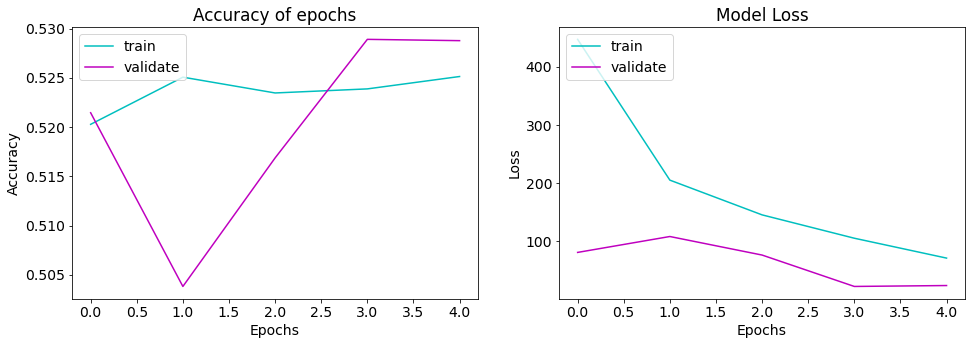

In [48]:
plot_model(history_1)

In [49]:
result_1 = pd.DataFrame((score_train1[1], score_test1[1], score_train1[0], score_test1[0], model_time1)).T
result_1.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_1['model'] = 'Simple model'

### Embedding Layer

In [50]:
embedding_dim = 100

In [51]:
model_2 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [52]:
model_2.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [53]:
start_time = time.time()
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time2 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 1120s 395ms/step - loss: 0.5339 - accuracy: 0.7225 - val_loss: 0.5311 - val_accuracy: 0.7257
Epoch 2/5
2836/2836 [==============================] - 1044s 368ms/step - loss: 0.4273 - accuracy: 0.8057 - val_loss: 0.5522 - val_accuracy: 0.7272
Epoch 3/5
2836/2836 [==============================] - 1183s 417ms/step - loss: 0.3143 - accuracy: 0.8701 - val_loss: 0.5889 - val_accuracy: 0.7202
Epoch 4/5
2836/2836 [==============================] - 589s 208ms/step - loss: 0.2263 - accuracy: 0.9122 - val_loss: 0.6856 - val_accuracy: 0.7067
Epoch 5/5
2836/2836 [==============================] - 782s 276ms/step - loss: 0.1658 - accuracy: 0.9381 - val_loss: 0.7273 - val_accuracy: 0.7090


In [54]:
model_time2

4723.116452217102

In [55]:
score_train2 = model_2.evaluate(X_train, y_train, verbose=0)
score_test2 = model_2.evaluate(X_valid, y_val, verbose=0)

In [56]:
print('Train loss:', score_train2[0])
print('Train accuracy:', score_train2[1])
print('Test loss:', score_test2[0])
print('Test accuracy:', score_test2[1])

Train loss: 0.10866745561361313
Train accuracy: 0.9621253609657288
Test loss: 0.7272925972938538
Test accuracy: 0.7089890837669373


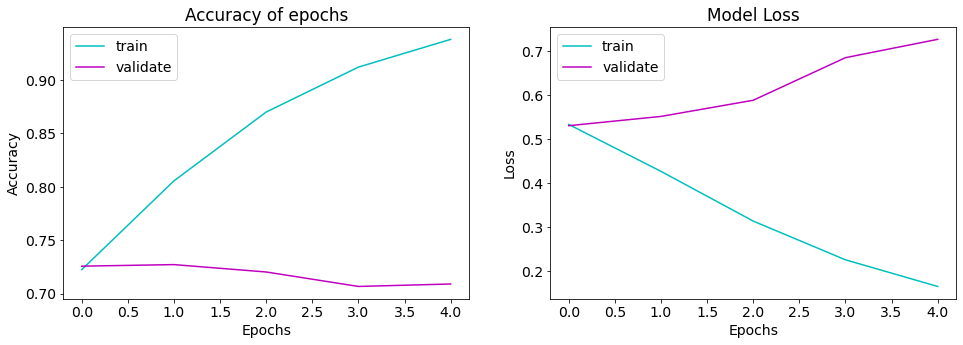

In [57]:
plot_model(history_2)

In [58]:
result_2 = pd.DataFrame((score_train2[1], score_test2[1], score_train2[0], score_test2[0], model_time2)).T
result_2.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_2['model'] = 'Embedding Layer'

### Add GlobalMaxPool1D

In [59]:
model_3 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [60]:
model_3.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [61]:
start_time = time.time()
history_3 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time3 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 597s 210ms/step - loss: 0.1253 - accuracy: 0.9543 - val_loss: 0.7760 - val_accuracy: 0.7040
Epoch 2/5
2836/2836 [==============================] - 599s 211ms/step - loss: 0.0974 - accuracy: 0.9649 - val_loss: 0.9053 - val_accuracy: 0.6984
Epoch 3/5
2836/2836 [==============================] - 975s 344ms/step - loss: 0.0770 - accuracy: 0.9727 - val_loss: 0.9375 - val_accuracy: 0.6965
Epoch 4/5
2836/2836 [==============================] - 710s 250ms/step - loss: 0.0619 - accuracy: 0.9784 - val_loss: 1.0029 - val_accuracy: 0.6972
Epoch 5/5
2836/2836 [==============================] - 690s 243ms/step - loss: 0.0508 - accuracy: 0.9829 - val_loss: 1.0793 - val_accuracy: 0.6817


In [62]:
model_time3

3571.220237016678

In [63]:
score_train3 = model_3.evaluate(X_train, y_train, verbose=0)
score_test3 = model_3.evaluate(X_valid, y_val, verbose=0)

In [64]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6933565139770508
Train accuracy: 0.48915231227874756
Test loss: 0.6933636665344238
Test accuracy: 0.49235111474990845


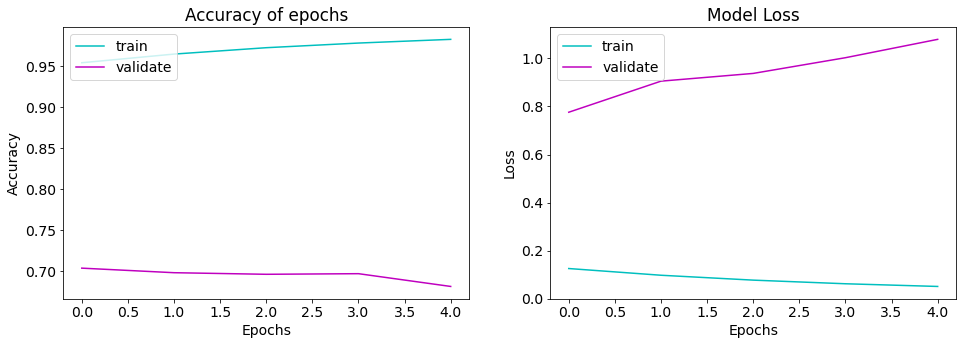

In [65]:
plot_model(history_3)

In [66]:
result_3 = pd.DataFrame((score_train3[1], score_test3[1], score_train3[0], score_test3[0], model_time3)).T
result_3.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_3['model'] = 'Add GlobalMaxPool1D'

### Convolutional Neural Networks (CNN)

In [67]:
model_4 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [68]:
model_4.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [69]:
start_time = time.time()
history_4 = model_4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time4 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 641s 226ms/step - loss: 0.5293 - accuracy: 0.7253 - val_loss: 0.5625 - val_accuracy: 0.7178
Epoch 2/5
2836/2836 [==============================] - 921s 325ms/step - loss: 0.3937 - accuracy: 0.8246 - val_loss: 0.5850 - val_accuracy: 0.7303
Epoch 3/5
2836/2836 [==============================] - 688s 243ms/step - loss: 0.2428 - accuracy: 0.9045 - val_loss: 0.6009 - val_accuracy: 0.7442
Epoch 4/5
2836/2836 [==============================] - 1032s 364ms/step - loss: 0.1451 - accuracy: 0.9468 - val_loss: 0.6728 - val_accuracy: 0.7348
Epoch 5/5
2836/2836 [==============================] - 636s 224ms/step - loss: 0.0911 - accuracy: 0.9682 - val_loss: 0.7931 - val_accuracy: 0.7209


In [70]:
model_time4

3920.3624544143677

In [71]:
score_train4 = model_4.evaluate(X_train, y_train, verbose=0)
score_test4 = model_4.evaluate(X_valid, y_val, verbose=0)

In [72]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6933565139770508
Train accuracy: 0.48915231227874756
Test loss: 0.6933636665344238
Test accuracy: 0.49235111474990845


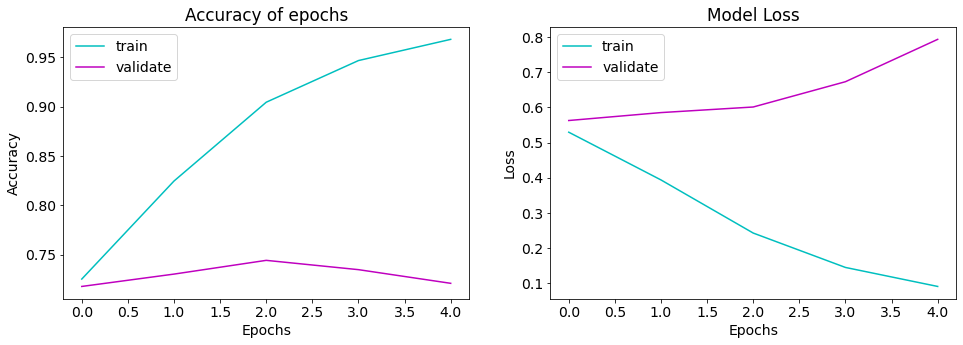

In [73]:
plot_model(history_4)

In [74]:
result_4 = pd.DataFrame((score_train4[1], score_test4[1], score_train4[0], score_test4[0], model_time4)).T
result_4.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_4['model'] = 'CNN'

### Add Dropout

In [75]:
model_5 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [76]:
model_5.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [77]:
start_time = time.time()
history_5 = model_5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time5 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 653s 230ms/step - loss: 0.5401 - accuracy: 0.7193 - val_loss: 0.5422 - val_accuracy: 0.7219
Epoch 2/5
2836/2836 [==============================] - 961s 339ms/step - loss: 0.4384 - accuracy: 0.7986 - val_loss: 0.5447 - val_accuracy: 0.7410
Epoch 3/5
2836/2836 [==============================] - 660s 233ms/step - loss: 0.3211 - accuracy: 0.8669 - val_loss: 0.5683 - val_accuracy: 0.7368
Epoch 4/5
2836/2836 [==============================] - 1076s 379ms/step - loss: 0.2301 - accuracy: 0.9104 - val_loss: 0.6395 - val_accuracy: 0.7369
Epoch 5/5
2836/2836 [==============================] - 618s 218ms/step - loss: 0.1732 - accuracy: 0.9361 - val_loss: 0.6763 - val_accuracy: 0.7359


In [78]:
model_time5

3971.6288628578186

In [79]:
score_train5 = model_5.evaluate(X_train, y_train, verbose=0)
score_test5 = model_5.evaluate(X_valid, y_val, verbose=0)

In [80]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6933565139770508
Train accuracy: 0.48915231227874756
Test loss: 0.6933636665344238
Test accuracy: 0.49235111474990845


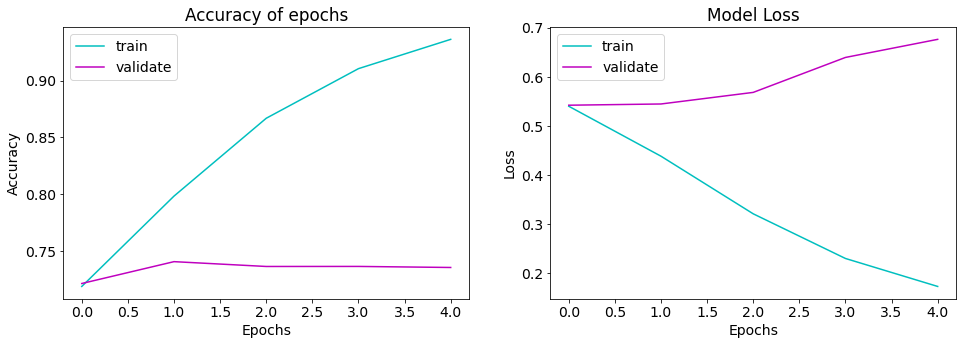

In [81]:
plot_model(history_5)

In [82]:
result_5 = pd.DataFrame((score_train5[1], score_test5[1], score_train5[0], score_test5[0], model_time5)).T
result_5.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_5['model'] = 'Add Dropout'

### CNN + LSTM

In [83]:
model_6 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [84]:
model_6.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [85]:
start_time = time.time()
history_6 = model_6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time6 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 677s 239ms/step - loss: 0.5357 - accuracy: 0.7231 - val_loss: 0.5325 - val_accuracy: 0.7297
Epoch 2/5
2836/2836 [==============================] - 688s 243ms/step - loss: 0.3892 - accuracy: 0.8263 - val_loss: 0.5287 - val_accuracy: 0.7489
Epoch 3/5
2836/2836 [==============================] - 644s 227ms/step - loss: 0.2526 - accuracy: 0.8972 - val_loss: 0.5885 - val_accuracy: 0.7424
Epoch 4/5
2836/2836 [==============================] - 614s 216ms/step - loss: 0.1924 - accuracy: 0.9246 - val_loss: 0.6667 - val_accuracy: 0.7323
Epoch 5/5
2836/2836 [==============================] - 685s 242ms/step - loss: 0.1583 - accuracy: 0.9389 - val_loss: 0.7391 - val_accuracy: 0.7279


In [86]:
model_time6

3313.338180541992

In [87]:
score_train6 = model_6.evaluate(X_train, y_train, verbose=0)
score_test6 = model_6.evaluate(X_valid, y_val, verbose=0)

In [88]:
print('Train loss:', score_train6[0])
print('Train accuracy:', score_train6[1])
print('Test loss:', score_test6[0])
print('Test accuracy:', score_test6[1])

Train loss: 0.10368457436561584
Train accuracy: 0.9608523845672607
Test loss: 0.7391241192817688
Test accuracy: 0.7279460430145264


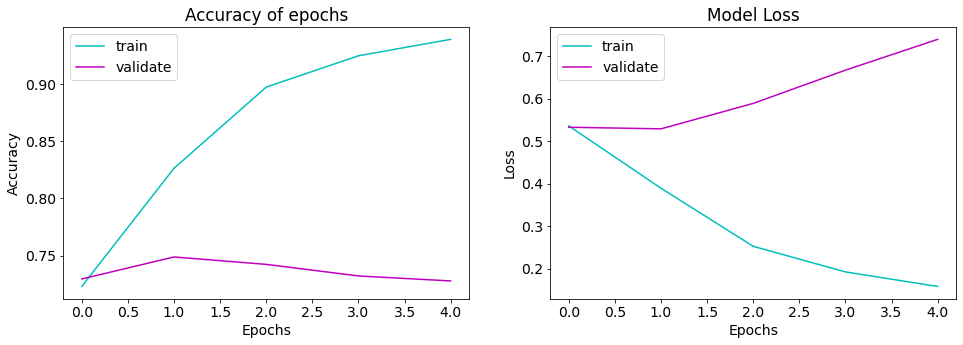

In [89]:
plot_model(history_6)

In [90]:
result_6 = pd.DataFrame((score_train6[1], score_test6[1], score_train6[0], score_test6[0], model_time6)).T
result_6.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_6['model'] = 'CNN + LSTM'

### GRU + CNN

In [91]:
model_7 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10)),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [92]:
model_7.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [93]:
start_time = time.time()
history_7 = model_7.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time7 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 693s 244ms/step - loss: 0.5457 - accuracy: 0.7192 - val_loss: 0.5459 - val_accuracy: 0.7269
Epoch 2/5
2836/2836 [==============================] - 694s 245ms/step - loss: 0.4425 - accuracy: 0.7975 - val_loss: 0.5307 - val_accuracy: 0.7484
Epoch 3/5
2836/2836 [==============================] - 684s 241ms/step - loss: 0.3220 - accuracy: 0.8673 - val_loss: 0.5670 - val_accuracy: 0.7447
Epoch 4/5
2836/2836 [==============================] - 707s 249ms/step - loss: 0.2451 - accuracy: 0.9040 - val_loss: 0.6228 - val_accuracy: 0.7360
Epoch 5/5
2836/2836 [==============================] - 783s 276ms/step - loss: 0.2050 - accuracy: 0.9222 - val_loss: 0.6434 - val_accuracy: 0.7393


In [94]:
model_time7

3568.805894613266

In [95]:
score_train7 = model_7.evaluate(X_train, y_train, verbose=0)
score_test7 = model_7.evaluate(X_valid, y_val, verbose=0)

In [96]:
print('Train loss:', score_train7[0])
print('Train accuracy:', score_train7[1])
print('Test loss:', score_test7[0])
print('Test accuracy:', score_test7[1])

Train loss: 0.14557696878910065
Train accuracy: 0.9443424940109253
Test loss: 0.643434464931488
Test accuracy: 0.7393202185630798


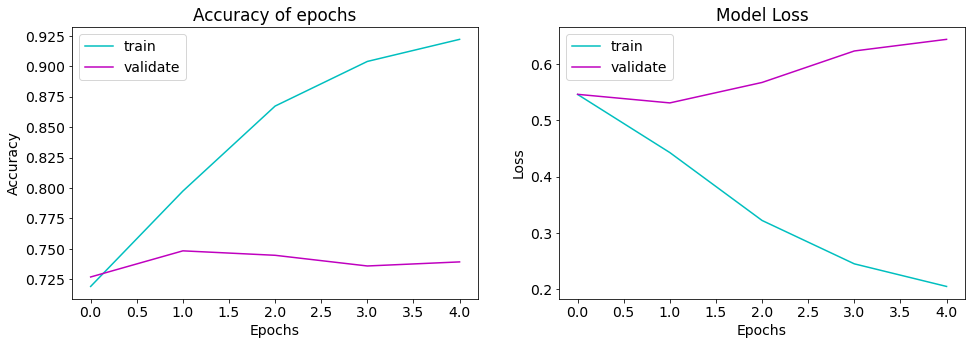

In [97]:
plot_model(history_7)

In [98]:
result_7 = pd.DataFrame((score_train7[1], score_test7[1], score_train7[0], score_test7[0], model_time7)).T
result_7.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_7['model'] = 'GRU + CNN'

### Results

In [132]:
final_results = pd.concat([baseline_lr, baseline_lsvc, result_1, result_2, result_3, result_4, result_5, result_6, result_7], axis=0)

In [133]:
final_results.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,time,train_loss,test_loss
1,CountVectorizer_LR2,0.91816,0.75360,45.81606,NaN,NaN
0,CountVectorizer_LR,0.90335,0.73998,52.44985,NaN,NaN
0,GRU + CNN,0.94434,0.73932,3568.80589,0.14558,0.64343
1,TfidfVectorizer_LSVC,0.96287,0.73817,13.05381,NaN,NaN
2,HashingVectorizer_LSVC,0.93225,0.73782,7.82649,NaN,NaN
2,TfidfVectorizer_LR,0.84350,0.73756,49.06377,NaN,NaN
0,Add Dropout,0.96820,0.73593,3971.62886,0.09476,0.67631
0,CNN + LSTM,0.96085,0.72795,3313.33818,0.10368,0.73912
0,CountVectorizer_LSVC,0.97973,0.72777,67.67929,NaN,NaN
3,HashingVectorizer_LR,0.80842,0.72684,36.98275,NaN,NaN


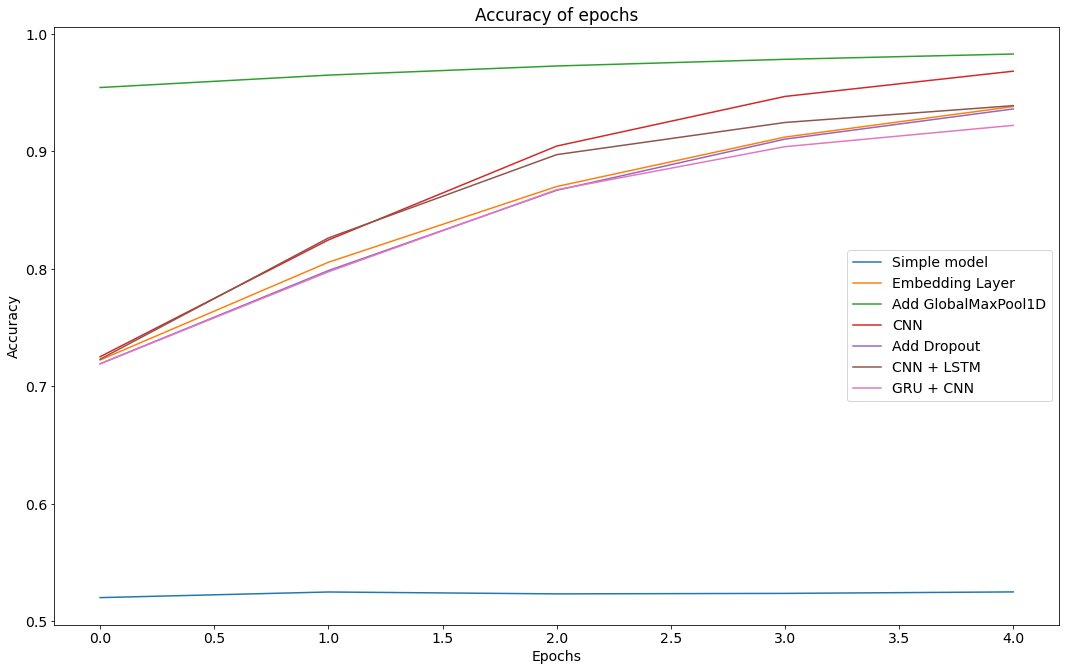

In [101]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['accuracy'], label='Simple model')
plt.plot(history_2.history['accuracy'], label='Embedding Layer')
plt.plot(history_3.history['accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['accuracy'], label='CNN')
plt.plot(history_5.history['accuracy'], label='Add Dropout')
plt.plot(history_6.history['accuracy'], label='CNN + LSTM')
plt.plot(history_7.history['accuracy'], label='GRU + CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

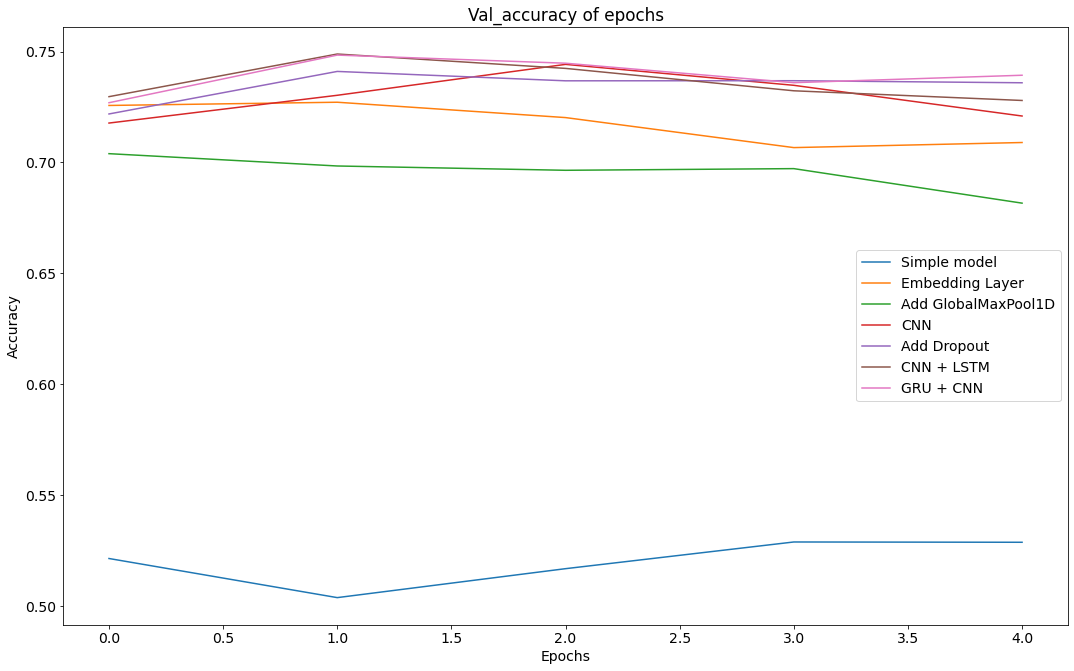

In [102]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['val_accuracy'], label='Simple model')
plt.plot(history_2.history['val_accuracy'], label='Embedding Layer')
plt.plot(history_3.history['val_accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['val_accuracy'], label='CNN')
plt.plot(history_5.history['val_accuracy'], label='Add Dropout')
plt.plot(history_6.history['val_accuracy'], label='CNN + LSTM')
plt.plot(history_7.history['val_accuracy'], label='GRU + CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Val_accuracy of epochs')
plt.show()